In [14]:
# DELIVERABLE FOR THE PROJECT:
# "KINEMATICS OF MOBILITY"
# David Pastor-Escuredo (Life D Lab)
# Licencia MIT

In [15]:
#Copyright <2019> <David Pastor Escuredo>

#Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

#The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [18]:
import pandas as pd
import numpy as np
import json
from nltk.tokenize import word_tokenize
import re
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from PIL import Image
import time
from datetime import datetime, timedelta, date
from os import listdir
from os.path import isfile, join
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pickle
import math

%matplotlib inline

def getday(d):
    if d<10:
        ds='0'+str(d)
    else:
        ds=str(d)
    return ds

def distAntenna(origvector,desvector):
    d=math.pow((origvector[0]-desvector[0]),2)+math.pow((origvector[1]-desvector[1]),2)
    d=math.sqrt(d)

In [4]:
ant_file='antennas/antennas_colombia.csv'
#xls=pd.ExcelFile(ant_file)#,decimal=',')
#sheet=xls.parse(0)
sheet=pd.read_csv(ant_file,delimiter=',')
print(len(sheet))
print(sheet.head())
aid=sheet['antenna_id']
ss=sheet[aid=='083F2711']
print(ss)
print(ss.LONGITUD.values-ss.LATITUD.values)
d=ss.LONGITUD.values[0]-ss.LATITUD.values[0]

29865
   index  LATITUD  LONGITUD Celda_HEX LAC_HEX antenna_id
0      0   4.6092  -74.0718      2711    083F   083F2711
1      1   4.6092  -74.0718      2712    083F   083F2712
2      2   4.6092  -74.0718      2713    083F   083F2713
3      3   4.6092  -74.0718      2714    083F   083F2714
4      4   4.6092  -74.0718      2715    083F   083F2715
   index  LATITUD  LONGITUD Celda_HEX LAC_HEX antenna_id
0      0   4.6092  -74.0718      2711    083F   083F2711
[-78.681]


In [6]:
trajpath='./trajs/'
deltaMax=200
for yDay in range(1,2):
    with open(trajpath+'usersTracking'+'_'+str(yDay)+'.tff', 'rb') as fpp:
        usersTracking=pickle.load(fpp)
    users=usersTracking.keys()
    usersl=list(users)
    print(len(users))
    avuser=[]
    G=nx.DiGraph()
    for i in range(0,1):
        u=usersl[i]
    #for u in users:
        #print(usersTracking[u].keys())
        avisited=usersTracking[u]['ss']
        tvisited=usersTracking[u]['ts']
        avuser.append(len(avisited))
        #print(len(avisited))
        #print(usersTracking[u][yDay]['sc'])
        for i in range(1, len(avisited)):
            orig=avisited[i]
            dest=avisited[i+1]
            so=sheet[aid==orig]
            sd=sheet[aid==dest]
            #print(so)
            #print(sd)
            solon=so.LONGITUD.values[0]
            sdlon=sd.LONGITUD.values[0]
            solat=so.LATITUD.values[0]
            sdlat=sd.LATITUD.values[0]
            distance=math.sqrt((solon-sdlon)**2+(solat-sdlat)**2)
            delta=tvisited[i+1]-tvisited[i]
            ##print(distance)
            ##print(delta)
            
            if orig=='139E2CC5' or dest=='139E2CC5':
                print(so)
                print(sd)
                
            #print(avisited[i])
            #print(avisited[i+1])
            if not G.has_node(orig):
                G.add_node(orig)
            if not G.has_node(dest):
                G.add_node(dest)
            if not G.has_edge(orig,dest):  
                G.add_edge(orig,dest)  
                G[orig][dest]['weight']=1
            else:
                G[orig][dest]['weight']=G[orig][dest]['weight']+1

    with open('nets/Net_'+str(yDay)+'.cnf', 'wb') as handle:
        pickle.dump(G, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

1822272


KeyError: 19

In [19]:
ant_file='antennas/antennas_colombia.csv'
sheet=pd.read_csv(ant_file,delimiter=',')
print(sheet.head())
aid=sheet['antenna_id']

   index  LATITUD  LONGITUD Celda_HEX LAC_HEX antenna_id
0      0   4.6092  -74.0718      2711    083F   083F2711
1      1   4.6092  -74.0718      2712    083F   083F2712
2      2   4.6092  -74.0718      2713    083F   083F2713
3      3   4.6092  -74.0718      2714    083F   083F2714
4      4   4.6092  -74.0718      2715    083F   083F2715


In [26]:
#Creates mobility network
#The traffic of the network is computed in a daily basis
#OUTDATED

trajpath='./trajs/'
ant_file='antennas/antennas_colombia.csv'
sheet=pd.read_csv(ant_file,delimiter=',')
print(len(sheet))
aid=sheet['antenna_id']

for yDay in range(1,2):
    with open(trajpath+'usersTracking'+'_'+str(yDay)+'.tff', 'rb') as fpp:
        usersTracking=pickle.load(fpp)
    users=usersTracking.keys()
    print(len(users))
    avuser=[]
    avuser2=[]
    G=nx.DiGraph()
    for u in users:
        #print(usersTracking[u].keys())
        avisited=usersTracking[u]['ss']
        tvisited=usersTracking[u]['ts']
        avuser.append(len(avisited))
        avuser2.append(usersTracking[u]['sc'])
        #print(len(avisited))
        #print(usersTracking[u][yDay]['sc'])
        if len(avisited)>1:
            for i in range(1, len(avisited)):
                orig=avisited[i]
                dest=avisited[i+1]
                ao=sheet[aid==orig]
                ad=sheet[aid==dest]
                aolat=ao.LATITUD.values[0]
                aolon=ao.LONGITUD.values[0]
                adlat=ad.LATITUD.values[0]
                adlon=ad.LONGITUD.values[0]
                #print(avisited[i])
                #print(avisited[i+1])
                if not G.has_node(orig):
                    G.add_node(orig)
                if not G.has_node(dest):
                    G.add_node(dest)
                if not G.has_edge(orig,dest):  
                    G.add_edge(orig,dest)  
                    #Flow
                    G[orig][dest]['weight']=1
                    #Distance
                    d=math.sqrt(math.pow((aolat-adlat),2)+math.pow((aolon-adlon),2))
                    G[orig][dest]['distance']=d
                    #Speed-> too sensitive to sampling
                    delta=tvisited[i+1]-tvisited[i]
                    G[orig][dest]['time']=delta
                else:
                    G[orig][dest]['weight']=G[orig][dest]['weight']+1
                    G[orig][dest]['time']=G[orig][dest]['time']+delta
        else:
            orig=avisited[1]
            if not G.has_node(orig):
                G.add_node(orig)

    with open('nets/Net_'+str(yDay)+'.cnf', 'wb') as handle:
        pickle.dump(G, handle, protocol=pickle.HIGHEST_PROTOCOL)

29865
1822272


In [ ]:
print(np.max(avuser))
print(np.max(avuser2))

(array([  1.77825400e+06,   3.60180000e+04,   6.05200000e+03,
          1.40300000e+03,   3.96000000e+02,   1.08000000e+02,
          3.10000000e+01,   6.00000000e+00,   3.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   27.9,   54.8,   81.7,  108.6,  135.5,  162.4,  189.3,
         216.2,  243.1,  270. ]),
 <a list of 10 Patch objects>)

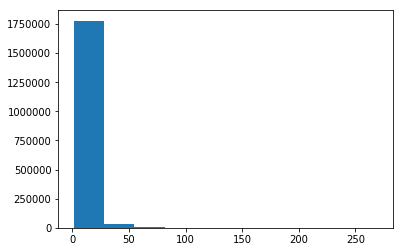

In [14]:
plt.hist(avuser)

In [29]:
datapath='./'
netpath=datapath+'nets/'
with open(netpath+'Net'+'_'+str(1)+'.cnf', 'rb') as fpp:
        G=pickle.load(fpp)
ns=G.nodes()
Gund=G.to_undirected()
    #Directed graph
ns=G.nodes()

    

KeyError: 10

In [44]:
ns=list(ns)
n1=ns[10]
n2='1042AB62'
#print(G[n1])
print(G[n1][n2])
print(G[n2][n1])
print(Gund[n1][n2])
print(Gund[n2][n1])

{'weight': 5, 'distance': 0.019509269591659693, 'time': 48490}
{'weight': 4, 'distance': 0.019509269591659693, 'time': 9857}
{'weight': 5, 'distance': 0.019509269591659693, 'time': 48490}
{'weight': 5, 'distance': 0.019509269591659693, 'time': 48490}


In [48]:
G=nx.DiGraph()
G.add_node('1')
G.add_node('2')
G.add_edge('1','2') 
print(G.has_edge('1','2')) 
print(G.has_edge('2','1')) 

True
False


In [53]:
#We save descriptors for each node of the network
#Descriptors are calculated in a daily basis
#OUTDATED
datapath='./'
netpath=datapath+'nets/'
GD={}
for yDay in range(1,2):
    with open(netpath+'Net'+'_'+str(yDay)+'.cnf', 'rb') as fpp:
        G=pickle.load(fpp)
    ns=G.nodes()
    
    print(len(ns))
    #Algorithms to compute different types of centrality
    Grev=G.reverse()
    #Closeness centrality
    CICN=nx.current_flow_closeness_centrality(G,weight='weight')
    COCN=nx.current_flow_closeness_centrality(Grev,weight='weight')
    #Betweenness centrality
    BICN=nx.current_flow_betweenness_centrality(G, weight='weight')
    BOCN=nx.current_flow_betweenness_centrality(Grev,weight='weight')
    #Degree centrality
    DICN=nx.in_degree_centrality(G)
    DOCN=nx.out_degree_centrality(G)
    #Eigenvalue centrality
    EICN=nx.eigenvector_centrality(G,weight='weight')
    EOCN=nx.eigenvector_centrality(Grev,weight='weight')
    
    for n in ns:
        #print(n)
        if n not in GD:
            GD[n]={}
            
        #Descriptor degree
        ind=G.in_degree(n)
        outd=G.out_degree(n)
        GD[n]['ind']=ind
        GD[n]['outd']=outd
        
        #Centrality
        GD[n]['in_eigenvalue']=EICN[n]
        GD[n]['out_eigenvalue']=EOCN[n]
        GD[n]['in_degree']=DICN[n]
        GD[n]['out_degree']=DOCN[n]
        GD[n]['in_betweenness']=BICN[n]
        GD[n]['out_betweenness']=BOCN[n]
        GD[n]['in_closeness']=CICN[n]
        GD[n]['out_closeness']=COCN[n]
        
        #Edge descriptors statistics: Flow, distance, time
        succ=G.successors(n)
        lensuc=len(succ)
        pred=G.predecessors(n)
        lenpred=len(pred)
        
        out_flow=0
        in_flow=0
        out_dis=0
        in_dis=0
        out_delta=0
        in_delta=0
        
        for ns in succ:
            out_flow=out_flow+G[n][ns]['weight']
            out_dis=out_dis+G[n][ns]['distance']
            out_delta=out_delta+G[n][ns]['time']
            out_delta=out_delta/out_flow
        
        for np in pred:
            in_flow=in_flow+G[np][n]['weight']
            in_dis=in_dis+G[np][n]['distance']
            in_delta=in_delta+G[np][n]['time']
            in_delta=in_delta/in_flow
            
        ave_out_flow=out_flow/lensuc
        ave_in_flow=in_flow/lenpred
        
        out_dis=out_dis/lensuc
        in_dis=in_dis/lenpred
        
        out_delta=out_delta/lensuc
        in_delta=in_delta/lenpred
        
        GD[n]['out_flow']=out_flow
        GD[n]['in_flow']=in_flow
        GD[n]['out_ave_flow']=ave_out_flow
        GD[n]['in_ave_flow']=ave_in_flow
        GD[n]['out_distace']=out_dist
        GD[n]['in_distace']=in_dist
        GD[n]['out_time']=out_delta
        GD[n]['in_time']=in_delta
        
        #We could add socio-economic descriptors to the node
        
    with open('nets/ND_'+str(yDay)+'.cnf', 'wb') as handle:
        pickle.dump(GD, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Finished '+str(yDay))

23545


NetworkXNotImplemented: not implemented for directed type

In [27]:
from timeit import default_timer as timer

start = timer()
end = timer()
print(end - start)

0.0020303691271692514
